# Autoencoders in SciKeras

Autencoders are an approach to use nearual networks to distill data into it's most important features, thereby compressing the data. We will be following the [Keras tutorial](https://blog.keras.io/building-autoencoders-in-keras.html) on the topic, which goes much more in depth and breadth than we will here. You are highly encouraged to check out that tutorial if you want to learn about autoencoders in the general sense.

## Table of contents

* [1. Setup](#1.-Setup)
* [2. Data](#2.-Data)
* [3. Define Keras Model](#3.-Define-Keras-Model)
* [4. Training](#4.-Training)
* [5. Explore Results](#5.-Explore-Results)

## 1. Setup

In [1]:
try:
    import scikeras
except ImportError:
    !python -m pip install scikeras

Silence TensorFlow logging to keep output succinct.

In [2]:
import warnings
from tensorflow import get_logger
get_logger().setLevel('ERROR')
warnings.filterwarnings("ignore", message="Setting the random state for TF")

In [3]:
import numpy as np
from scikeras.wrappers import KerasClassifier, KerasRegressor
from tensorflow import keras

## 2. Data

We load the dataset from the Keras tutorial. The dataset consists of images of cats and dogs.

In [4]:
from tensorflow.keras.datasets import mnist
import numpy as np


(x_train, _), (x_test, _) = mnist.load_data()
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))
print(x_train.shape)
print(x_test.shape)

    8192/11490434 [..............................] - ETA: 0s

  270336/11490434 [..............................] - ETA: 2s

 3604480/11490434 [========>.....................] - ETA: 0s

11493376/11490434 [==============================] - 0s 0us/step


(60000, 784)
(10000, 784)


## 3. Define Keras Model

We will be defining a very simple autencoder. We define _three_ model building methods:

1. One to build a full end-to-end autoencoder.
2. One to create a model that includes only the encoder portion.
3. One that creates a model that includes only the decoder portion.

The only variable we give our model is the encoding dimensions, which will be a hyperparemter of our final transformer.

In [5]:
from tensorflow import keras


def get_fit_model(encoding_dim: int) -> keras.Model:
    """Get an autoencoder.

    This autoencoder compresses a 28x28 image (784 pixels) down to a feature of length
    `encoding_dim`, and tries to reconstruct the input image from that vector.
    """
    input_img = keras.Input(shape=(784,), name="input")
    encoded = keras.layers.Dense(encoding_dim, activation='relu', name="encoded")(input_img)
    decoded = keras.layers.Dense(784, activation='sigmoid', name="output")(encoded)
    autoencoder_model = keras.Model(input_img, decoded)
    return autoencoder_model

def get_tf_model(fit_model: keras.Model) -> keras.Model:
    """Get an encoder model.

    We do this by extracting the encoding layer from the fitted autoencoder model.
    """
    return keras.Model(fit_model.get_layer("input").input, fit_model.get_layer("encoded").output)

def get_inverse_tf_model(fit_model: keras.Model, encoding_dim: int) -> keras.Model:
    """Get an deencoder model.

    We do this by extracting the deencoding layer from the fitted autoencoder model
    and adding a new Keras input layer.
    """
    encoded_input = keras.Input(shape=(encoding_dim,))
    output = fit_model.get_layer("output")(encoded_input)
    return keras.Model(encoded_input, output)

Next we create a class that that will enable the `transform` and `fit_transform` methods, as well as integrating all three of our models into a single estimator.

In [6]:
from sklearn.base import TransformerMixin, clone
from scikeras.wrappers import BaseWrapper


class KerasTransformer(BaseWrapper, TransformerMixin):
    """A class that enables transform and fit_transform.
    """

    def __init__(self, *args, tf_est: BaseWrapper = None, inv_tf_est: BaseWrapper = None, **kwargs) -> None:
        super().__init__(*args, **kwargs)
        self.tf_est = tf_est
        self.inv_tf_est = inv_tf_est


    def fit(self, X, sample_weight=None):
        super().fit(X=X, y=X, sample_weight=sample_weight)
        self.tf_est_ = clone(self.tf_est)
        self.inv_tf_est_ = clone(self.inv_tf_est)
        self.tf_est_.set_params(fit_model=self.model_)
        self.inv_tf_est_.set_params(fit_model=self.model_, encoding_dim=self.encoding_dim)
        X = self.feature_encoder_.transform(X)
        self.tf_est_.initialize(X=X)
        X_tf = self.tf_est_.predict(X=X)
        self.inv_tf_est_.initialize(X_tf)
        return self

    def transform(self, X):
        X = self.feature_encoder_.transform(X)
        X_tf = self.tf_est_.predict(X)
        return X_tf
    
    def inverse_transform(self, X_tf):
        X = self.inv_tf_est_.predict(X_tf)
        X = self.feature_encoder_.inverse_transform(X)
        return X

Next, we wrap the Keras Model with Scikeras. Note that for our encoder/decoder estimators, we do not need to provide a loss function since no training will be done. We do however need to have the `fit_model` and `encoding_dim` so that these will be settable by `BaseWrapper.set_params`.

In [7]:
tf_est = BaseWrapper(model=get_tf_model, fit_model=None, verbose=0)
inv_tf_est = BaseWrapper(model=get_inverse_tf_model, fit_model=None, encoding_dim=None, verbose=0)
autoencoder = KerasTransformer(model=get_fit_model, tf_est=tf_est, inv_tf_est=inv_tf_est, loss="binary_crossentropy", encoding_dim=32, epochs=5)

## 4. Training

To train the model, we pass the input images as both the features and the target. This will train the layers to compress the data as accurately as possible between the encoder and decoder. Note that we only pass the `X` parameter, since we defined the mapping `y=X` in `KerasTransformer.fit` above.

In [8]:
_ = autoencoder.fit(X=x_train)

Epoch 1/5


   1/1875 [..............................] - ETA: 12:47 - loss: 0.6943

  27/1875 [..............................] - ETA: 3s - loss: 0.5600   

  53/1875 [..............................] - ETA: 3s - loss: 0.4809

  79/1875 [>.............................] - ETA: 3s - loss: 0.4375

 105/1875 [>.............................] - ETA: 3s - loss: 0.4093

 132/1875 [=>............................] - ETA: 3s - loss: 0.3882

 157/1875 [=>............................] - ETA: 3s - loss: 0.3730

 183/1875 [=>............................] - ETA: 3s - loss: 0.3601

 210/1875 [==>...........................] - ETA: 3s - loss: 0.3488

 237/1875 [==>...........................] - ETA: 3s - loss: 0.3391

 263/1875 [===>..........................] - ETA: 3s - loss: 0.3309

 290/1875 [===>..........................] - ETA: 3s - loss: 0.3233

 317/1875 [====>.........................] - ETA: 3s - loss: 0.3165

 345/1875 [====>.........................] - ETA: 2s - loss: 0.3101

 373/1875 [====>.........................] - ETA: 2s - loss: 0.3043

 400/1875 [=====>........................] - ETA: 2s - loss: 0.2992

 425/1875 [=====>........................] - ETA: 2s - loss: 0.2949

 448/1875 [======>.......................] - ETA: 2s - loss: 0.2911

 473/1875 [======>.......................] - ETA: 2s - loss: 0.2872

 500/1875 [=======>......................] - ETA: 2s - loss: 0.2834

 527/1875 [=======>......................] - ETA: 2s - loss: 0.2797

 555/1875 [=======>......................] - ETA: 2s - loss: 0.2761

 582/1875 [========>.....................] - ETA: 2s - loss: 0.2729

 608/1875 [========>.....................] - ETA: 2s - loss: 0.2700

 634/1875 [=========>....................] - ETA: 2s - loss: 0.2672

 660/1875 [=========>....................] - ETA: 2s - loss: 0.2645

 686/1875 [=========>....................] - ETA: 2s - loss: 0.2619

 716/1875 [==========>...................] - ETA: 2s - loss: 0.2591

 746/1875 [==========>...................] - ETA: 2s - loss: 0.2565

 772/1875 [===========>..................] - ETA: 2s - loss: 0.2543

 797/1875 [===========>..................] - ETA: 2s - loss: 0.2522

 824/1875 [============>.................] - ETA: 2s - loss: 0.2501

 850/1875 [============>.................] - ETA: 1s - loss: 0.2481

 878/1875 [=============>................] - ETA: 1s - loss: 0.2461

 904/1875 [=============>................] - ETA: 1s - loss: 0.2443

 931/1875 [=============>................] - ETA: 1s - loss: 0.2424

 958/1875 [==============>...............] - ETA: 1s - loss: 0.2407

 986/1875 [==============>...............] - ETA: 1s - loss: 0.2389

1012/1875 [===============>..............] - ETA: 1s - loss: 0.2373

1039/1875 [===============>..............] - ETA: 1s - loss: 0.2357

1066/1875 [================>.............] - ETA: 1s - loss: 0.2341

1092/1875 [================>.............] - ETA: 1s - loss: 0.2327

1119/1875 [================>.............] - ETA: 1s - loss: 0.2312

1144/1875 [=================>............] - ETA: 1s - loss: 0.2299

1171/1875 [=================>............] - ETA: 1s - loss: 0.2285

1197/1875 [==================>...........] - ETA: 1s - loss: 0.2272

1226/1875 [==================>...........] - ETA: 1s - loss: 0.2258

1252/1875 [===================>..........] - ETA: 1s - loss: 0.2246

1280/1875 [===================>..........] - ETA: 1s - loss: 0.2233

1304/1875 [===================>..........] - ETA: 1s - loss: 0.2222

1330/1875 [====================>.........] - ETA: 1s - loss: 0.2211

1357/1875 [====================>.........] - ETA: 0s - loss: 0.2199

1378/1875 [=====================>........] - ETA: 0s - loss: 0.2190

1398/1875 [=====================>........] - ETA: 0s - loss: 0.2182

1421/1875 [=====================>........] - ETA: 0s - loss: 0.2173

1445/1875 [======================>.......] - ETA: 0s - loss: 0.2164

1457/1875 [======================>.......] - ETA: 0s - loss: 0.2159

1478/1875 [======================>.......] - ETA: 0s - loss: 0.2151

1498/1875 [======================>.......] - ETA: 0s - loss: 0.2143

1521/1875 [=======================>......] - ETA: 0s - loss: 0.2135

1547/1875 [=======================>......] - ETA: 0s - loss: 0.2125

1568/1875 [========================>.....] - ETA: 0s - loss: 0.2118

1590/1875 [========================>.....] - ETA: 0s - loss: 0.2110

1612/1875 [========================>.....] - ETA: 0s - loss: 0.2103

1632/1875 [=========================>....] - ETA: 0s - loss: 0.2096

1652/1875 [=========================>....] - ETA: 0s - loss: 0.2089

1671/1875 [=========================>....] - ETA: 0s - loss: 0.2083

1694/1875 [==========================>...] - ETA: 0s - loss: 0.2075

1715/1875 [==========================>...] - ETA: 0s - loss: 0.2069

1743/1875 [==========================>...] - ETA: 0s - loss: 0.2060

1768/1875 [===========================>..] - ETA: 0s - loss: 0.2052

1794/1875 [===========================>..] - ETA: 0s - loss: 0.2045

1820/1875 [============================>.] - ETA: 0s - loss: 0.2037

1845/1875 [============================>.] - ETA: 0s - loss: 0.2030

1871/1875 [============================>.] - ETA: 0s - loss: 0.2022

1875/1875 [==============================] - 4s 2ms/step - loss: 0.2021


Epoch 2/5
   1/1875 [..............................] - ETA: 4s - loss: 0.1087

  23/1875 [..............................] - ETA: 4s - loss: 0.1101

  48/1875 [..............................] - ETA: 3s - loss: 0.1100

  73/1875 [>.............................] - ETA: 3s - loss: 0.1100

  98/1875 [>.............................] - ETA: 3s - loss: 0.1100

 124/1875 [>.............................] - ETA: 3s - loss: 0.1099

 151/1875 [=>............................] - ETA: 3s - loss: 0.1098

 174/1875 [=>............................] - ETA: 3s - loss: 0.1097

 196/1875 [==>...........................] - ETA: 3s - loss: 0.1096

 221/1875 [==>...........................] - ETA: 3s - loss: 0.1094

 245/1875 [==>...........................] - ETA: 3s - loss: 0.1093

 269/1875 [===>..........................] - ETA: 3s - loss: 0.1092

 293/1875 [===>..........................] - ETA: 3s - loss: 0.1091

 319/1875 [====>.........................] - ETA: 3s - loss: 0.1091

 344/1875 [====>.........................] - ETA: 3s - loss: 0.1090

 369/1875 [====>.........................] - ETA: 3s - loss: 0.1089

 392/1875 [=====>........................] - ETA: 3s - loss: 0.1088

 420/1875 [=====>........................] - ETA: 3s - loss: 0.1087

 444/1875 [======>.......................] - ETA: 3s - loss: 0.1087

 470/1875 [======>.......................] - ETA: 2s - loss: 0.1086

 496/1875 [======>.......................] - ETA: 2s - loss: 0.1085

 523/1875 [=======>......................] - ETA: 2s - loss: 0.1085

 550/1875 [=======>......................] - ETA: 2s - loss: 0.1084

 576/1875 [========>.....................] - ETA: 2s - loss: 0.1083

 599/1875 [========>.....................] - ETA: 2s - loss: 0.1083

 625/1875 [=========>....................] - ETA: 2s - loss: 0.1082

 651/1875 [=========>....................] - ETA: 2s - loss: 0.1081

 679/1875 [=========>....................] - ETA: 2s - loss: 0.1080

 701/1875 [==========>...................] - ETA: 2s - loss: 0.1080

 725/1875 [==========>...................] - ETA: 2s - loss: 0.1079

 752/1875 [===========>..................] - ETA: 2s - loss: 0.1078

 777/1875 [===========>..................] - ETA: 2s - loss: 0.1078

 801/1875 [===========>..................] - ETA: 2s - loss: 0.1077

 824/1875 [============>.................] - ETA: 2s - loss: 0.1077

 849/1875 [============>.................] - ETA: 2s - loss: 0.1076

 875/1875 [=============>................] - ETA: 2s - loss: 0.1076

 900/1875 [=============>................] - ETA: 2s - loss: 0.1075

 927/1875 [=============>................] - ETA: 1s - loss: 0.1074

 953/1875 [==============>...............] - ETA: 1s - loss: 0.1074

 979/1875 [==============>...............] - ETA: 1s - loss: 0.1073

1006/1875 [===============>..............] - ETA: 1s - loss: 0.1073

1033/1875 [===============>..............] - ETA: 1s - loss: 0.1072

1053/1875 [===============>..............] - ETA: 1s - loss: 0.1072

1080/1875 [================>.............] - ETA: 1s - loss: 0.1071

1098/1875 [================>.............] - ETA: 1s - loss: 0.1071

1121/1875 [================>.............] - ETA: 1s - loss: 0.1070

1147/1875 [=================>............] - ETA: 1s - loss: 0.1070

1171/1875 [=================>............] - ETA: 1s - loss: 0.1069

1196/1875 [==================>...........] - ETA: 1s - loss: 0.1069

1215/1875 [==================>...........] - ETA: 1s - loss: 0.1068

1237/1875 [==================>...........] - ETA: 1s - loss: 0.1068

1264/1875 [===================>..........] - ETA: 1s - loss: 0.1068

1290/1875 [===================>..........] - ETA: 1s - loss: 0.1067

1317/1875 [====================>.........] - ETA: 1s - loss: 0.1067

1344/1875 [====================>.........] - ETA: 1s - loss: 0.1066

1365/1875 [====================>.........] - ETA: 1s - loss: 0.1066

1383/1875 [=====================>........] - ETA: 1s - loss: 0.1065

1409/1875 [=====================>........] - ETA: 0s - loss: 0.1065

1436/1875 [=====================>........] - ETA: 0s - loss: 0.1064

1455/1875 [======================>.......] - ETA: 0s - loss: 0.1064

1475/1875 [======================>.......] - ETA: 0s - loss: 0.1064

1499/1875 [======================>.......] - ETA: 0s - loss: 0.1063

1521/1875 [=======================>......] - ETA: 0s - loss: 0.1063

1547/1875 [=======================>......] - ETA: 0s - loss: 0.1063

1567/1875 [========================>.....] - ETA: 0s - loss: 0.1062

1590/1875 [========================>.....] - ETA: 0s - loss: 0.1062

1614/1875 [========================>.....] - ETA: 0s - loss: 0.1061

1629/1875 [=========================>....] - ETA: 0s - loss: 0.1061

1647/1875 [=========================>....] - ETA: 0s - loss: 0.1061

1669/1875 [=========================>....] - ETA: 0s - loss: 0.1061

1693/1875 [==========================>...] - ETA: 0s - loss: 0.1060

1717/1875 [==========================>...] - ETA: 0s - loss: 0.1060

1739/1875 [==========================>...] - ETA: 0s - loss: 0.1059

1762/1875 [===========================>..] - ETA: 0s - loss: 0.1059

1783/1875 [===========================>..] - ETA: 0s - loss: 0.1059

1804/1875 [===========================>..] - ETA: 0s - loss: 0.1058

1823/1875 [============================>.] - ETA: 0s - loss: 0.1058

1846/1875 [============================>.] - ETA: 0s - loss: 0.1058

1873/1875 [============================>.] - ETA: 0s - loss: 0.1057

1875/1875 [==============================] - 4s 2ms/step - loss: 0.1057


Epoch 3/5
   1/1875 [..............................] - ETA: 5s - loss: 0.0960

  22/1875 [..............................] - ETA: 4s - loss: 0.0952

  41/1875 [..............................] - ETA: 4s - loss: 0.0959

  62/1875 [..............................] - ETA: 4s - loss: 0.0965

  82/1875 [>.............................] - ETA: 4s - loss: 0.0967

 102/1875 [>.............................] - ETA: 4s - loss: 0.0968

 124/1875 [>.............................] - ETA: 4s - loss: 0.0970

 145/1875 [=>............................] - ETA: 4s - loss: 0.0972

 165/1875 [=>............................] - ETA: 4s - loss: 0.0973

 187/1875 [=>............................] - ETA: 4s - loss: 0.0974

 207/1875 [==>...........................] - ETA: 4s - loss: 0.0974

 227/1875 [==>...........................] - ETA: 4s - loss: 0.0975

 249/1875 [==>...........................] - ETA: 4s - loss: 0.0975

 275/1875 [===>..........................] - ETA: 3s - loss: 0.0976

 295/1875 [===>..........................] - ETA: 3s - loss: 0.0976

 321/1875 [====>.........................] - ETA: 3s - loss: 0.0977

 339/1875 [====>.........................] - ETA: 3s - loss: 0.0977

 363/1875 [====>.........................] - ETA: 3s - loss: 0.0977

 385/1875 [=====>........................] - ETA: 3s - loss: 0.0978

 409/1875 [=====>........................] - ETA: 3s - loss: 0.0978

 430/1875 [=====>........................] - ETA: 3s - loss: 0.0978

 452/1875 [======>.......................] - ETA: 3s - loss: 0.0978

 476/1875 [======>.......................] - ETA: 3s - loss: 0.0979

 500/1875 [=======>......................] - ETA: 3s - loss: 0.0979

 518/1875 [=======>......................] - ETA: 3s - loss: 0.0979

 538/1875 [=======>......................] - ETA: 3s - loss: 0.0979

 565/1875 [========>.....................] - ETA: 3s - loss: 0.0979

 590/1875 [========>.....................] - ETA: 3s - loss: 0.0979

 617/1875 [========>.....................] - ETA: 2s - loss: 0.0979

 633/1875 [=========>....................] - ETA: 2s - loss: 0.0979

 656/1875 [=========>....................] - ETA: 2s - loss: 0.0979

 678/1875 [=========>....................] - ETA: 2s - loss: 0.0979

 700/1875 [==========>...................] - ETA: 2s - loss: 0.0979

 724/1875 [==========>...................] - ETA: 2s - loss: 0.0979

 744/1875 [==========>...................] - ETA: 2s - loss: 0.0979

 766/1875 [===========>..................] - ETA: 2s - loss: 0.0979

 789/1875 [===========>..................] - ETA: 2s - loss: 0.0980

 810/1875 [===========>..................] - ETA: 2s - loss: 0.0980

 833/1875 [============>.................] - ETA: 2s - loss: 0.0980

 852/1875 [============>.................] - ETA: 2s - loss: 0.0980

 874/1875 [============>.................] - ETA: 2s - loss: 0.0980

 895/1875 [=============>................] - ETA: 2s - loss: 0.0980

 917/1875 [=============>................] - ETA: 2s - loss: 0.0980

 937/1875 [=============>................] - ETA: 2s - loss: 0.0980

 960/1875 [==============>...............] - ETA: 2s - loss: 0.0980

 987/1875 [==============>...............] - ETA: 2s - loss: 0.0980

1013/1875 [===============>..............] - ETA: 2s - loss: 0.0980

1041/1875 [===============>..............] - ETA: 1s - loss: 0.0980

1066/1875 [================>.............] - ETA: 1s - loss: 0.0980

1089/1875 [================>.............] - ETA: 1s - loss: 0.0980

1116/1875 [================>.............] - ETA: 1s - loss: 0.0980

1141/1875 [=================>............] - ETA: 1s - loss: 0.0980

1170/1875 [=================>............] - ETA: 1s - loss: 0.0980

1190/1875 [==================>...........] - ETA: 1s - loss: 0.0980

1215/1875 [==================>...........] - ETA: 1s - loss: 0.0980

1241/1875 [==================>...........] - ETA: 1s - loss: 0.0980

1269/1875 [===================>..........] - ETA: 1s - loss: 0.0980

1296/1875 [===================>..........] - ETA: 1s - loss: 0.0980

1324/1875 [====================>.........] - ETA: 1s - loss: 0.0980

1351/1875 [====================>.........] - ETA: 1s - loss: 0.0980

1379/1875 [=====================>........] - ETA: 1s - loss: 0.0980

1407/1875 [=====================>........] - ETA: 1s - loss: 0.0980

1435/1875 [=====================>........] - ETA: 0s - loss: 0.0980

1462/1875 [======================>.......] - ETA: 0s - loss: 0.0980

1489/1875 [======================>.......] - ETA: 0s - loss: 0.0980

1517/1875 [=======================>......] - ETA: 0s - loss: 0.0980

1545/1875 [=======================>......] - ETA: 0s - loss: 0.0979

1572/1875 [========================>.....] - ETA: 0s - loss: 0.0979

1596/1875 [========================>.....] - ETA: 0s - loss: 0.0979

1623/1875 [========================>.....] - ETA: 0s - loss: 0.0979

1650/1875 [=========================>....] - ETA: 0s - loss: 0.0979

1677/1875 [=========================>....] - ETA: 0s - loss: 0.0979

1703/1875 [==========================>...] - ETA: 0s - loss: 0.0979

1730/1875 [==========================>...] - ETA: 0s - loss: 0.0979

1757/1875 [===========================>..] - ETA: 0s - loss: 0.0979

1784/1875 [===========================>..] - ETA: 0s - loss: 0.0979

1812/1875 [===========================>..] - ETA: 0s - loss: 0.0979

1829/1875 [============================>.] - ETA: 0s - loss: 0.0979

1852/1875 [============================>.] - ETA: 0s - loss: 0.0979

1870/1875 [============================>.] - ETA: 0s - loss: 0.0979

1875/1875 [==============================] - 4s 2ms/step - loss: 0.0979


Epoch 4/5
   1/1875 [..............................] - ETA: 6s - loss: 0.0895

  23/1875 [..............................] - ETA: 4s - loss: 0.0940

  47/1875 [..............................] - ETA: 4s - loss: 0.0947

  63/1875 [>.............................] - ETA: 4s - loss: 0.0951

  85/1875 [>.............................] - ETA: 4s - loss: 0.0955

 107/1875 [>.............................] - ETA: 4s - loss: 0.0957

 126/1875 [=>............................] - ETA: 4s - loss: 0.0958

 149/1875 [=>............................] - ETA: 4s - loss: 0.0959

 169/1875 [=>............................] - ETA: 4s - loss: 0.0960

 187/1875 [=>............................] - ETA: 4s - loss: 0.0960

 207/1875 [==>...........................] - ETA: 4s - loss: 0.0961

 228/1875 [==>...........................] - ETA: 4s - loss: 0.0961

 247/1875 [==>...........................] - ETA: 4s - loss: 0.0961

 269/1875 [===>..........................] - ETA: 4s - loss: 0.0962

 287/1875 [===>..........................] - ETA: 4s - loss: 0.0962

 309/1875 [===>..........................] - ETA: 3s - loss: 0.0962

 329/1875 [====>.........................] - ETA: 3s - loss: 0.0962

 349/1875 [====>.........................] - ETA: 3s - loss: 0.0962

 370/1875 [====>.........................] - ETA: 3s - loss: 0.0962

 392/1875 [=====>........................] - ETA: 3s - loss: 0.0962

 413/1875 [=====>........................] - ETA: 3s - loss: 0.0962

 434/1875 [=====>........................] - ETA: 3s - loss: 0.0962

 456/1875 [======>.......................] - ETA: 3s - loss: 0.0962

 477/1875 [======>.......................] - ETA: 3s - loss: 0.0962

 500/1875 [=======>......................] - ETA: 3s - loss: 0.0962

 524/1875 [=======>......................] - ETA: 3s - loss: 0.0962

 541/1875 [=======>......................] - ETA: 3s - loss: 0.0962

 561/1875 [=======>......................] - ETA: 3s - loss: 0.0962

 586/1875 [========>.....................] - ETA: 3s - loss: 0.0962

 606/1875 [========>.....................] - ETA: 3s - loss: 0.0962

 628/1875 [=========>....................] - ETA: 3s - loss: 0.0962

 647/1875 [=========>....................] - ETA: 3s - loss: 0.0962

 670/1875 [=========>....................] - ETA: 3s - loss: 0.0962

 689/1875 [==========>...................] - ETA: 2s - loss: 0.0963

 713/1875 [==========>...................] - ETA: 2s - loss: 0.0963

 734/1875 [==========>...................] - ETA: 2s - loss: 0.0963

 762/1875 [===========>..................] - ETA: 2s - loss: 0.0963

 781/1875 [===========>..................] - ETA: 2s - loss: 0.0963

 803/1875 [===========>..................] - ETA: 2s - loss: 0.0963

 823/1875 [============>.................] - ETA: 2s - loss: 0.0963

 849/1875 [============>.................] - ETA: 2s - loss: 0.0963

 875/1875 [=============>................] - ETA: 2s - loss: 0.0963

 902/1875 [=============>................] - ETA: 2s - loss: 0.0963

 929/1875 [=============>................] - ETA: 2s - loss: 0.0963

 956/1875 [==============>...............] - ETA: 2s - loss: 0.0963

 984/1875 [==============>...............] - ETA: 2s - loss: 0.0963

1011/1875 [===============>..............] - ETA: 2s - loss: 0.0963

1039/1875 [===============>..............] - ETA: 1s - loss: 0.0963

1067/1875 [================>.............] - ETA: 1s - loss: 0.0963

1096/1875 [================>.............] - ETA: 1s - loss: 0.0963

1118/1875 [================>.............] - ETA: 1s - loss: 0.0963

1138/1875 [=================>............] - ETA: 1s - loss: 0.0963

1159/1875 [=================>............] - ETA: 1s - loss: 0.0963

1181/1875 [=================>............] - ETA: 1s - loss: 0.0963

1199/1875 [==================>...........] - ETA: 1s - loss: 0.0963

1222/1875 [==================>...........] - ETA: 1s - loss: 0.0963

1238/1875 [==================>...........] - ETA: 1s - loss: 0.0963

1261/1875 [===================>..........] - ETA: 1s - loss: 0.0963

1280/1875 [===================>..........] - ETA: 1s - loss: 0.0963

1301/1875 [===================>..........] - ETA: 1s - loss: 0.0963

1324/1875 [====================>.........] - ETA: 1s - loss: 0.0963

1346/1875 [====================>.........] - ETA: 1s - loss: 0.0963

1369/1875 [====================>.........] - ETA: 1s - loss: 0.0963

1388/1875 [=====================>........] - ETA: 1s - loss: 0.0962

1409/1875 [=====================>........] - ETA: 1s - loss: 0.0962

1432/1875 [=====================>........] - ETA: 1s - loss: 0.0962

1455/1875 [======================>.......] - ETA: 0s - loss: 0.0963

1477/1875 [======================>.......] - ETA: 0s - loss: 0.0963

1501/1875 [=======================>......] - ETA: 0s - loss: 0.0963

1518/1875 [=======================>......] - ETA: 0s - loss: 0.0963

1545/1875 [=======================>......] - ETA: 0s - loss: 0.0963

1571/1875 [========================>.....] - ETA: 0s - loss: 0.0963

1596/1875 [========================>.....] - ETA: 0s - loss: 0.0963

1621/1875 [========================>.....] - ETA: 0s - loss: 0.0963

1647/1875 [=========================>....] - ETA: 0s - loss: 0.0963

1674/1875 [=========================>....] - ETA: 0s - loss: 0.0963

1700/1875 [==========================>...] - ETA: 0s - loss: 0.0963

1723/1875 [==========================>...] - ETA: 0s - loss: 0.0963

1745/1875 [==========================>...] - ETA: 0s - loss: 0.0963

1766/1875 [===========================>..] - ETA: 0s - loss: 0.0963

1789/1875 [===========================>..] - ETA: 0s - loss: 0.0963

1807/1875 [===========================>..] - ETA: 0s - loss: 0.0963

1828/1875 [============================>.] - ETA: 0s - loss: 0.0963

1851/1875 [============================>.] - ETA: 0s - loss: 0.0963

1871/1875 [============================>.] - ETA: 0s - loss: 0.0962

1875/1875 [==============================] - 4s 2ms/step - loss: 0.0962


Epoch 5/5
   1/1875 [..............................] - ETA: 3s - loss: 0.1013

  25/1875 [..............................] - ETA: 3s - loss: 0.0966

  45/1875 [..............................] - ETA: 4s - loss: 0.0961

  68/1875 [>.............................] - ETA: 4s - loss: 0.0958

  91/1875 [>.............................] - ETA: 4s - loss: 0.0958

 112/1875 [>.............................] - ETA: 4s - loss: 0.0957

 136/1875 [=>............................] - ETA: 3s - loss: 0.0957

 161/1875 [=>............................] - ETA: 3s - loss: 0.0957

 187/1875 [=>............................] - ETA: 3s - loss: 0.0957

 210/1875 [==>...........................] - ETA: 3s - loss: 0.0957

 236/1875 [==>...........................] - ETA: 3s - loss: 0.0957

 263/1875 [===>..........................] - ETA: 3s - loss: 0.0957

 290/1875 [===>..........................] - ETA: 3s - loss: 0.0957

 316/1875 [====>.........................] - ETA: 3s - loss: 0.0957

 343/1875 [====>.........................] - ETA: 3s - loss: 0.0957

 369/1875 [====>.........................] - ETA: 3s - loss: 0.0957

 397/1875 [=====>........................] - ETA: 3s - loss: 0.0957

 424/1875 [=====>........................] - ETA: 2s - loss: 0.0957

 452/1875 [======>.......................] - ETA: 2s - loss: 0.0957

 478/1875 [======>.......................] - ETA: 2s - loss: 0.0957

 503/1875 [=======>......................] - ETA: 2s - loss: 0.0957

 526/1875 [=======>......................] - ETA: 2s - loss: 0.0957

 551/1875 [=======>......................] - ETA: 2s - loss: 0.0957

 572/1875 [========>.....................] - ETA: 2s - loss: 0.0957

 592/1875 [========>.....................] - ETA: 2s - loss: 0.0957

 617/1875 [========>.....................] - ETA: 2s - loss: 0.0957

 643/1875 [=========>....................] - ETA: 2s - loss: 0.0957

 671/1875 [=========>....................] - ETA: 2s - loss: 0.0957

 697/1875 [==========>...................] - ETA: 2s - loss: 0.0957

 720/1875 [==========>...................] - ETA: 2s - loss: 0.0957

 745/1875 [==========>...................] - ETA: 2s - loss: 0.0957

 769/1875 [===========>..................] - ETA: 2s - loss: 0.0957

 791/1875 [===========>..................] - ETA: 2s - loss: 0.0957

 816/1875 [============>.................] - ETA: 2s - loss: 0.0957

 839/1875 [============>.................] - ETA: 2s - loss: 0.0957

 863/1875 [============>.................] - ETA: 2s - loss: 0.0957

 883/1875 [=============>................] - ETA: 2s - loss: 0.0957

 909/1875 [=============>................] - ETA: 2s - loss: 0.0957

 934/1875 [=============>................] - ETA: 1s - loss: 0.0957

 961/1875 [==============>...............] - ETA: 1s - loss: 0.0956

 987/1875 [==============>...............] - ETA: 1s - loss: 0.0956

1014/1875 [===============>..............] - ETA: 1s - loss: 0.0956

1041/1875 [===============>..............] - ETA: 1s - loss: 0.0956

1065/1875 [================>.............] - ETA: 1s - loss: 0.0956

1091/1875 [================>.............] - ETA: 1s - loss: 0.0956

1116/1875 [================>.............] - ETA: 1s - loss: 0.0956

1142/1875 [=================>............] - ETA: 1s - loss: 0.0956

1167/1875 [=================>............] - ETA: 1s - loss: 0.0956

1193/1875 [==================>...........] - ETA: 1s - loss: 0.0956

1219/1875 [==================>...........] - ETA: 1s - loss: 0.0956

1242/1875 [==================>...........] - ETA: 1s - loss: 0.0956

1268/1875 [===================>..........] - ETA: 1s - loss: 0.0956

1295/1875 [===================>..........] - ETA: 1s - loss: 0.0956

1322/1875 [====================>.........] - ETA: 1s - loss: 0.0956

1348/1875 [====================>.........] - ETA: 1s - loss: 0.0956

1375/1875 [=====================>........] - ETA: 1s - loss: 0.0956

1402/1875 [=====================>........] - ETA: 0s - loss: 0.0956

1429/1875 [=====================>........] - ETA: 0s - loss: 0.0956

1456/1875 [======================>.......] - ETA: 0s - loss: 0.0956

1484/1875 [======================>.......] - ETA: 0s - loss: 0.0956

1511/1875 [=======================>......] - ETA: 0s - loss: 0.0956

1538/1875 [=======================>......] - ETA: 0s - loss: 0.0956

1565/1875 [========================>.....] - ETA: 0s - loss: 0.0956

1593/1875 [========================>.....] - ETA: 0s - loss: 0.0956

1620/1875 [========================>.....] - ETA: 0s - loss: 0.0956

1647/1875 [=========================>....] - ETA: 0s - loss: 0.0956

1674/1875 [=========================>....] - ETA: 0s - loss: 0.0956

1701/1875 [==========================>...] - ETA: 0s - loss: 0.0956

1726/1875 [==========================>...] - ETA: 0s - loss: 0.0956

1753/1875 [===========================>..] - ETA: 0s - loss: 0.0956

1778/1875 [===========================>..] - ETA: 0s - loss: 0.0956

1797/1875 [===========================>..] - ETA: 0s - loss: 0.0956

1818/1875 [============================>.] - ETA: 0s - loss: 0.0956

1838/1875 [============================>.] - ETA: 0s - loss: 0.0956

1857/1875 [============================>.] - ETA: 0s - loss: 0.0956

1875/1875 [==============================] - 4s 2ms/step - loss: 0.0956


Next, we round trip the test dataset and explore the performance of the autoencoder.

In [9]:
roundtrip_imgs = autoencoder.inverse_transform(autoencoder.transform(x_test))

## 5. Explore Results

Let's compare our inputs to lossy decoded outputs:

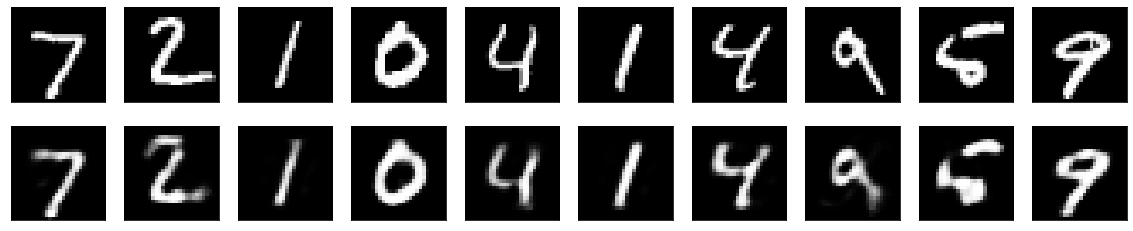

In [10]:
import matplotlib.pyplot as plt


n = 10  # How many digits we will display
plt.figure(figsize=(20, 4))
for i in range(n):
    # Display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(roundtrip_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

What about the compression? Let's check the sizes of the arrays.

In [11]:
encoded_imgs = autoencoder.transform(x_test)
print(f"x_test.shape[1]: {x_test.shape[1]}")
print(f"encoded_imgs.shape[1]: {encoded_imgs.shape[1]}")
cr = round((encoded_imgs.nbytes/x_test.nbytes), 2)
print(f"Compression ratio: 1/{1/cr:.0f}")

x_test.shape[1]: 784
encoded_imgs.shape[1]: 32
Compression ratio: 1/25
